In [ ]:
pip install opencv-python

In [1]:
from keras.preprocessing.image import img_to_array,load_img
import numpy as np
import glob
import os
from skimage.transform import resize
import argparse
import tensorflow as tf

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
video_source_path_train= "/content/drive/My Drive/ESML_Project/Avenue Dataset/training_videos"
video_source_path_= "/content/drive/My Drive/ESML_Project/Data"

In [ ]:
def create_dir(path):
	if not os.path.exists(path):
		os.makedirs(path)

def remove_old_images(path):
	filelist = glob.glob(os.path.join(path, "*.png"))
	for f in filelist:
		os.remove(f)

In [ ]:
#List of all Videos in the Source Directory.
videos=os.listdir(video_source_path_train)
videos.sort()
print("Found ",len(videos)," training video")

#Make a temp dir to store all the frames
create_dir(video_source_path_train+'/frames')

#Remove old images
remove_old_images(video_source_path_train+'/frames')

framepath_train=video_source_path_train+'/frames'

In [ ]:
global imagestore
imagestore = []

def store(image_path):
    img = load_img(image_path)
    img1 = img_to_array(img)
    #print(img1.shape)
    img2 = resize(img1, (227, 227, 3))
    #print(img2.shape)
    gray = 0.2989 * img2[:, :, 0] + 0.5870 * img2[:, :, 1] + 0.1140 * img2[:, :, 2]
    #print(gray.shape)
    imagestore.append(gray)

In [ ]:
global frame_num
frame_num=0

In [ ]:
import cv2
import os

def extract_frames(video_name, input_video_path, output_directory, fps):
    global frame_num
    video_path = os.path.join(input_video_path,video_name)
    cap = cv2.VideoCapture(video_path)
    fps = fps*1000
    # Check if video opened successfully
    if not cap.isOpened():
        print("Error: Could not open video.")
        exit()

    # Directory to save frames, change as needed
    os.makedirs(output_directory, exist_ok=True)

    # Frame counter

    start_time = cap.get(cv2.CAP_PROP_POS_MSEC)

    while True:
        ret, frame = cap.read()

        # Check if end of video or error
        if not ret:
            print("End of video or error.")
            break

        # Capture frames every n seconds of video runtime
        current_time = cap.get(cv2.CAP_PROP_POS_MSEC)
        if (current_time - start_time) >= fps:
            frame_filename = os.path.join(output_directory, f'frame_{frame_num}.jpg')
            cv2.imwrite(frame_filename, frame)
            frame_num += 1

            # Update the start time for the next 5-second interval
            start_time = current_time

    cap.release()


In [ ]:
def create_volumes(frames, volume_size=10, strides=[1, 2, 3]):
    """
    Create video volumes with different strides.
    """
    volumes = []
    for stride in strides:
        for i in range(0, len(frames) - volume_size * stride, stride):
            volume = np.array(frames[i:i + volume_size * stride:stride])
            if volume.shape[0] == volume_size:
                volumes.append(volume)
    return np.array(volumes)

In [ ]:
def preprocess_avenue(imagestore):
  imagestore_nparr = np.array(imagestore)
  print(imagestore_nparr.shape)
  volumes = create_volumes(imagestore_nparr)
  print(volumes.shape)
  a,b,c,d=volumes.shape
  #bca
  volumes.resize(c,d,a*b)
  #Normalize
  volumes=(volumes-volumes.mean())/(volumes.std())
  #Clip negative Values
  volumes=np.clip(volumes,0,1)
  print(volumes.shape)
  return volumes

In [ ]:
# Avenue
imagestore=[]
for video in videos:
  print(video)
  extract_frames(video,video_source_path_train,framepath_train,1)
images=os.listdir(framepath_train)
images.sort()
for image in images:
    image_path=os.path.join(framepath_train,image)
    store(image_path)

01.avi
End of video or error.
02.avi
End of video or error.
03.avi
End of video or error.
04.avi
End of video or error.
05.avi
End of video or error.
06.avi
End of video or error.
07.avi
End of video or error.
08.avi
End of video or error.
09.avi
End of video or error.
10.avi
End of video or error.
11.avi
End of video or error.
12.avi
End of video or error.
13.avi
End of video or error.
14.avi
End of video or error.
15.avi
End of video or error.
16.avi
End of video or error.


In [ ]:
vols=preprocess_avenue(imagestore)
np.save(video_source_path_+'/training_Avenue.npy',vols)

(604, 227, 227)
(1078, 10, 227, 227)
(227, 227, 10780)


In [ ]:
import shutil
shutil.rmtree(framepath_train)

In [ ]:
from keras.models import Sequential
from keras.layers import Conv3D, ConvLSTM2D, Conv3DTranspose
from keras.layers import BatchNormalization, Dropout
from keras.regularizers import l2
def load_Model(input_shape=(227, 227, 10, 1), l2_penalty=0.01):
    """
    Return the enhanced model used for abnormal event detection in videos
    using a spatiotemporal autoencoder with batch normalization and dropout.
    """
    model = Sequential()

    # First Conv3D layer
    model.add(Conv3D(filters=128, kernel_size=(11, 11, 1), strides=(4, 4, 1),
                     padding='valid', input_shape=input_shape, activation='tanh',
                     kernel_regularizer=l2(l2_penalty)))
    model.add(BatchNormalization())

    # Second Conv3D layer
    model.add(Conv3D(filters=64, kernel_size=(5, 5, 1), strides=(2, 2, 1),
                     padding='valid', activation='tanh',
                     kernel_regularizer=l2(l2_penalty)))
    model.add(BatchNormalization())

    # First ConvLSTM2D layer
    model.add(ConvLSTM2D(filters=64, kernel_size=(3, 3), strides=1, padding='same',
                         dropout=0.4, recurrent_dropout=0.3, return_sequences=True,
                         kernel_regularizer=l2(l2_penalty)))
    model.add(BatchNormalization())

    # Second ConvLSTM2D layer
    model.add(ConvLSTM2D(filters=64, kernel_size=(3, 3), strides=1, padding='same',
                         dropout=0.3, recurrent_dropout=0.2, return_sequences=True,
                         kernel_regularizer=l2(l2_penalty)))
    model.add(BatchNormalization())

    # Third ConvLSTM2D layer
    model.add(ConvLSTM2D(filters=64, kernel_size=(3, 3), strides=1, return_sequences=True,
                         padding='same', dropout=0.2, recurrent_dropout=0.2,
                         kernel_regularizer=l2(l2_penalty)))
    model.add(BatchNormalization())

    # First Conv3DTranspose layer
    model.add(Conv3DTranspose(filters=128, kernel_size=(5, 5, 1), strides=(2, 2, 1),
                              padding='valid', activation='tanh',
                              kernel_regularizer=l2(l2_penalty)))
    model.add(BatchNormalization())

    # Second Conv3DTranspose layer
    model.add(Conv3DTranspose(filters=1, kernel_size=(11, 11, 1), strides=(4, 4, 1),
                              padding='valid', activation='tanh',
                              kernel_regularizer=l2(l2_penalty)))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

    return model

# # Load the model
model = load_Model()
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 55, 55, 10, 128)   15616     
                                                                 
 batch_normalization (Batch  (None, 55, 55, 10, 128)   512       
 Normalization)                                                  
                                                                 
 conv3d_1 (Conv3D)           (None, 26, 26, 10, 64)    204864    
                                                                 
 batch_normalization_1 (Bat  (None, 26, 26, 10, 64)    256       
 chNormalization)                                                
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 26, 26, 10, 64)    295168    
                                                                 
 batch_normalization_2 (Bat  (None, 26, 26, 10, 64)    2

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
import tensorflow as tf

video_source_path_= "/content/drive/My Drive/ESML_Project/Processor"
X_train=np.load(video_source_path_+'/training_Avenue.npy')
frames=X_train.shape[2]
print("frames : ", frames)
frames=frames-frames%10

X_train=X_train[:,:,:frames]
X_train=X_train.reshape(-1,227,227,10)
X_train=np.expand_dims(X_train,axis=4)
Y_train=X_train.copy()



epochs=60
batch_size=16


#model=tf.keras.models.load_model(video_source_path_+"/AnomalyDetector_F.h5")
model = load_Model()
callback_save = ModelCheckpoint(video_source_path_+"/AnomalyDetector_Avenue.h5",
									monitor="loss", save_best_only=True)

callback_early_stopping = EarlyStopping(monitor='loss', patience=10)

print('Model has been loaded')

model.fit(X_train,Y_train,
			  batch_size=batch_size,
			  epochs=epochs,
			  callbacks = [callback_save,callback_early_stopping]
			  )
model.save(video_source_path_+"/AnomalyDetector_Avenue.h5")

frames :  10780
Model has been loaded
Epoch 1/60
68/68 [==============================] - ETA: 0s - loss: 1.1921 - accuracy: 0.6292

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


68/68 [==============================] - 57s 479ms/step - loss: 1.1921 - accuracy: 0.6292
Epoch 2/60
68/68 [==============================] - 32s 473ms/step - loss: 0.1250 - accuracy: 0.7394
Epoch 3/60
68/68 [==============================] - 32s 474ms/step - loss: 0.0796 - accuracy: 0.7525
Epoch 4/60
68/68 [==============================] - 31s 463ms/step - loss: 0.0906 - accuracy: 0.7521
Epoch 5/60
68/68 [==============================] - 32s 476ms/step - loss: 0.0660 - accuracy: 0.7600
Epoch 6/60
68/68 [==============================] - 33s 478ms/step - loss: 0.0618 - accuracy: 0.7633
Epoch 7/60
68/68 [==============================] - 32s 476ms/step - loss: 0.0586 - accuracy: 0.7649
Epoch 8/60
68/68 [==============================] - 32s 471ms/step - loss: 0.0832 - accuracy: 0.7589
Epoch 9/60
68/68 [==============================] - 33s 484ms/step - loss: 0.0576 - accuracy: 0.7676
Epoch 10/60
68/68 [==============================] - 34s 497ms/step - loss: 0.0504 - accuracy: 0.7716


# **TESTING BLOCKS**

In [ ]:
video_source_path= "/content/drive/My Drive/ESML_Project/Avenue Dataset/testing_videos"
video_source_path_1= "/content/drive/My Drive/ESML_Project/Processor"
def create_dir(path):
	if not os.path.exists(path):
		os.makedirs(path)

def remove_old_images(path):
	filelist = glob.glob(os.path.join(path, "*.png"))
	for f in filelist:
		os.remove(f)
#List of all Videos in the Source Directory.
videos=os.listdir(video_source_path)
videos.sort()
print("Found ",len(videos)," testing video")


#Make a temp dir to store all the frames
create_dir(video_source_path+'/frames')

#Remove old images
remove_old_images(video_source_path+'/frames')

framepath=video_source_path+'/frames'



Found  21  testing video


In [ ]:
for video in videos:
  extract_frames(video,video_source_path,framepath,1)
images=os.listdir(framepath)
images.sort()
for image in images:
  image_path=os.path.join(framepath,image)
  store(image_path)



End of video or error.
End of video or error.
End of video or error.
End of video or error.
End of video or error.
End of video or error.
End of video or error.
End of video or error.
End of video or error.
End of video or error.
End of video or error.
End of video or error.
End of video or error.
End of video or error.
End of video or error.
End of video or error.
End of video or error.
End of video or error.
End of video or error.
End of video or error.
End of video or error.


In [ ]:
import numpy as np

# Assuming frame_paths is a list of strings (file paths)
frame_paths = []

# Convert list to numpy array


In [ ]:
for i in range(frame_num):
  frame_paths.append(framepath+'/frame_'+str(i)+'.jpg')


In [ ]:
#imagestore=np.array(imagestore)
imagestore_nparr = np.array(imagestore)
print(imagestore_nparr.shape)
#volumes = create_volumes(imagestore_nparr)
a,b,c=imagestore_nparr.shape
#bca
imagestore_nparr.resize(b,c,a)
#Normalize
imagestore_nparr=(imagestore_nparr-imagestore_nparr.mean())/(imagestore_nparr.std())
#Clip negative Values
imagestore_nparr=np.clip(imagestore_nparr,0,1)
np.save(video_source_path_+'/testing_Avenue_all.npy',imagestore_nparr)
frame_paths_array = np.array(frame_paths, dtype=str)
#print(frame_paths_array)
np.save(video_source_path_+'/frame_paths_Avenue_all.npy', frame_paths_array)



(601, 227, 227)


In [3]:
from keras.models import load_model
import numpy as np
import tensorflow as tf

def mean_squared_loss(x1,x2):


	''' Compute Euclidean Distance Loss  between
	input frame and the reconstructed frame'''
	diff = x1 - x2
	sq_diff = tf.square(diff)
	sum_sq_diff = tf.reduce_sum(sq_diff)
	n_samples = tf.cast(tf.reduce_prod(tf.shape(diff)), tf.float32)
	mean_dist = tf.sqrt(sum_sq_diff) / n_samples
	return mean_dist



In [ ]:
import cv2
import numpy as np
import scipy.io as sio
from google.colab.patches import cv2_imshow

# Specify the video index
video_idx = 2

# Create the video capture object
cap = cv2.VideoCapture('/content/drive/My Drive/ESML_Project/Avenue Dataset/testing_videos/%.2d.avi' % video_idx)

# Get the number of frames
num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Load the label mask
label_mask_mat = sio.loadmat('/content/drive/My Drive/ESML_Project/Avenue Dataset/testing_label_mask/%d_label.mat' % video_idx)
label_mask = label_mask_mat['volLabel']
label_mask= label_mask[0]
# Convert the label mask to a NumPy array
label_mask_converted = np.array([[np.float64(elem) for elem in sublist] for sublist in label_mask])
#expanded_label_mask = np.expand_dims(label_mask, axis=(0, 1))
#print(num_frames)
#Iterate over all frames
for ii in range(0,num_frames,50):
    # Read the current frame
    ret, frame = cap.read()
    if not ret:
        break
    # Convert the frame to double precision
    frame = frame.astype(np.float64)

# Apply the label mask to the red channel
    frame[:, :, 0] = np.minimum(frame[:, :, 0] + 0.5 * label_mask_converted[ii], 1.0)

    # Display the current frame
    cv2_imshow(frame)

    # Wait for a key press to continue
    cv2.waitKey(1)

# Release the capture object
cap.release()

In [ ]:
label_mask_converted = np.array([[np.float64(elem) for elem in sublist] for sublist in label_mask])


In [ ]:
X_test=np.load(video_source_path_1+'/testing_Avenue_first2.npy')
frames=X_test.shape[2]
frames

296

601
1/1 [==============================] - 1s 746ms/step
Anomalous bunch of frames at bunch number 0
Anomalous Frame at Index: 0
Anomalous Frame at Index: 1
Anomalous Frame at Index: 2
Anomalous Frame at Index: 3
Anomalous Frame at Index: 4
Anomalous Frame at Index: 5


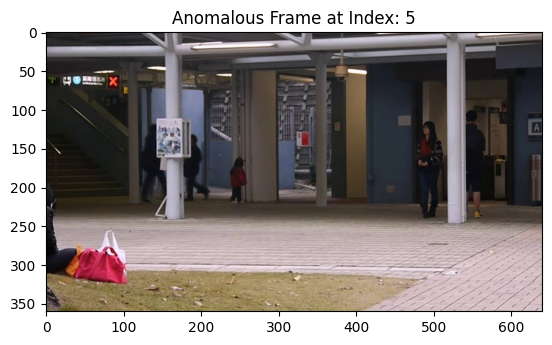

Anomalous Frame at Index: 6
Anomalous Frame at Index: 7
Anomalous Frame at Index: 8
Anomalous Frame at Index: 9
1/1 [==============================] - 0s 68ms/step
Anomalous bunch of frames at bunch number 1
Anomalous Frame at Index: 10
Anomalous Frame at Index: 11
Anomalous Frame at Index: 12
Anomalous Frame at Index: 13
Anomalous Frame at Index: 14
Anomalous Frame at Index: 15


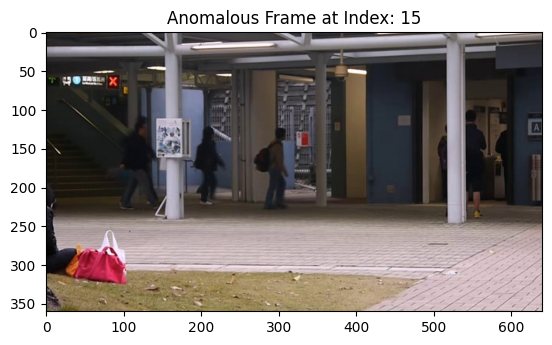

Anomalous Frame at Index: 16
Anomalous Frame at Index: 17
Anomalous Frame at Index: 18
Anomalous Frame at Index: 19
1/1 [==============================] - 0s 66ms/step
Anomalous bunch of frames at bunch number 2
Anomalous Frame at Index: 20
Anomalous Frame at Index: 21
Anomalous Frame at Index: 22
Anomalous Frame at Index: 23
Anomalous Frame at Index: 24
Anomalous Frame at Index: 25


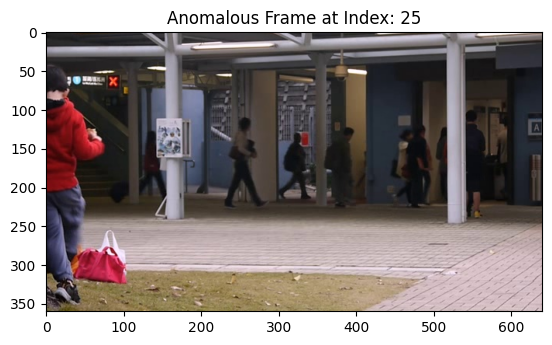

Anomalous Frame at Index: 26
Anomalous Frame at Index: 27
Anomalous Frame at Index: 28
Anomalous Frame at Index: 29
1/1 [==============================] - 0s 65ms/step
Anomalous bunch of frames at bunch number 3
Anomalous Frame at Index: 30
Anomalous Frame at Index: 31
Anomalous Frame at Index: 32
Anomalous Frame at Index: 33
Anomalous Frame at Index: 34
Anomalous Frame at Index: 35


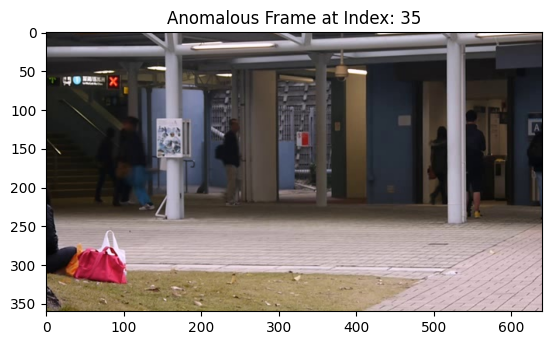

Anomalous Frame at Index: 36
Anomalous Frame at Index: 37
Anomalous Frame at Index: 38
Anomalous Frame at Index: 39
1/1 [==============================] - 0s 65ms/step
Anomalous bunch of frames at bunch number 4
Anomalous Frame at Index: 40
Anomalous Frame at Index: 41
Anomalous Frame at Index: 42
Anomalous Frame at Index: 43
Anomalous Frame at Index: 44
Anomalous Frame at Index: 45


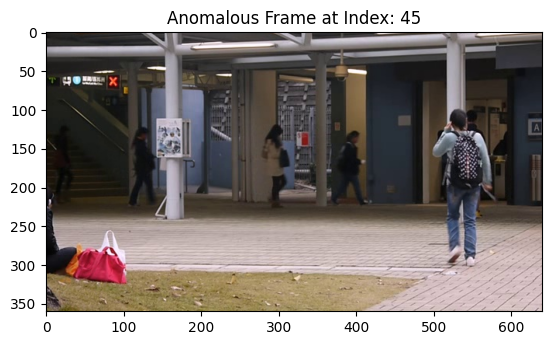

Anomalous Frame at Index: 46
Anomalous Frame at Index: 47
Anomalous Frame at Index: 48
Anomalous Frame at Index: 49
1/1 [==============================] - 0s 66ms/step
Anomalous bunch of frames at bunch number 5
Anomalous Frame at Index: 50
Anomalous Frame at Index: 51
Anomalous Frame at Index: 52
Anomalous Frame at Index: 53
Anomalous Frame at Index: 54
Anomalous Frame at Index: 55


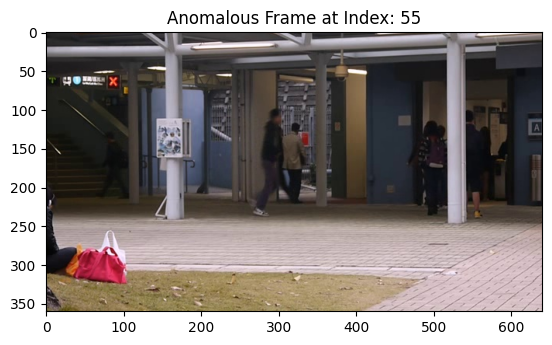

Anomalous Frame at Index: 56
Anomalous Frame at Index: 57
Anomalous Frame at Index: 58
Anomalous Frame at Index: 59
1/1 [==============================] - 0s 65ms/step
Anomalous bunch of frames at bunch number 6
Anomalous Frame at Index: 60
Anomalous Frame at Index: 61
Anomalous Frame at Index: 62
Anomalous Frame at Index: 63
Anomalous Frame at Index: 64
Anomalous Frame at Index: 65


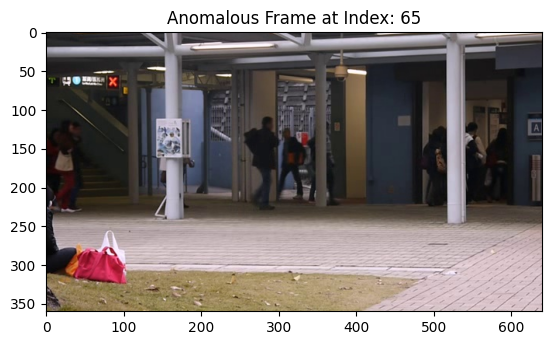

Anomalous Frame at Index: 66
Anomalous Frame at Index: 67
Anomalous Frame at Index: 68
Anomalous Frame at Index: 69
1/1 [==============================] - 0s 67ms/step
Anomalous bunch of frames at bunch number 7
Anomalous Frame at Index: 70
Anomalous Frame at Index: 71
Anomalous Frame at Index: 72
Anomalous Frame at Index: 73
Anomalous Frame at Index: 74
Anomalous Frame at Index: 75


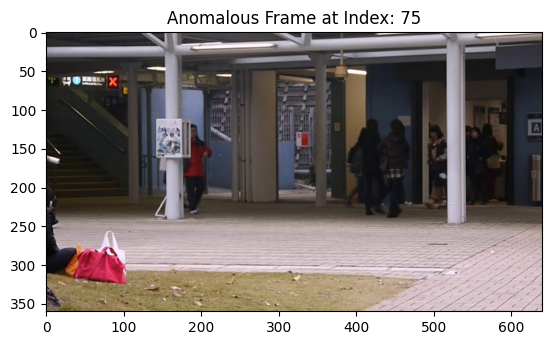

Anomalous Frame at Index: 76
Anomalous Frame at Index: 77
Anomalous Frame at Index: 78
Anomalous Frame at Index: 79
1/1 [==============================] - 0s 67ms/step
Anomalous bunch of frames at bunch number 8
Anomalous Frame at Index: 80
Anomalous Frame at Index: 81
Anomalous Frame at Index: 82
Anomalous Frame at Index: 83
Anomalous Frame at Index: 84
Anomalous Frame at Index: 85


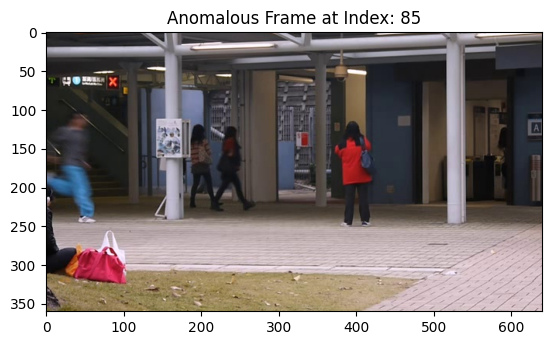

Anomalous Frame at Index: 86
Anomalous Frame at Index: 87
Anomalous Frame at Index: 88
Anomalous Frame at Index: 89
1/1 [==============================] - 0s 73ms/step
Anomalous bunch of frames at bunch number 9
Anomalous Frame at Index: 90
Anomalous Frame at Index: 91
Anomalous Frame at Index: 92
Anomalous Frame at Index: 93
Anomalous Frame at Index: 94
Anomalous Frame at Index: 95


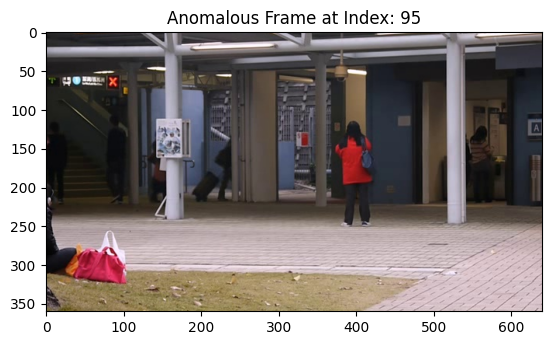

Anomalous Frame at Index: 96
Anomalous Frame at Index: 97
Anomalous Frame at Index: 98
Anomalous Frame at Index: 99
1/1 [==============================] - 0s 67ms/step
Anomalous bunch of frames at bunch number 10
Anomalous Frame at Index: 100
Anomalous Frame at Index: 101
Anomalous Frame at Index: 102
Anomalous Frame at Index: 103
Anomalous Frame at Index: 104
Anomalous Frame at Index: 105


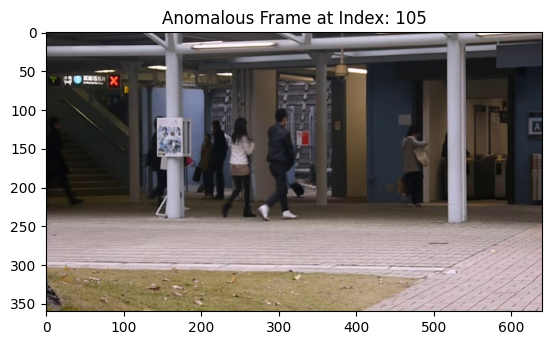

Anomalous Frame at Index: 106
Anomalous Frame at Index: 107
Anomalous Frame at Index: 108
Anomalous Frame at Index: 109
1/1 [==============================] - 0s 69ms/step
Anomalous bunch of frames at bunch number 11
Anomalous Frame at Index: 110
Anomalous Frame at Index: 111
Anomalous Frame at Index: 112
Anomalous Frame at Index: 113
Anomalous Frame at Index: 114
Anomalous Frame at Index: 115


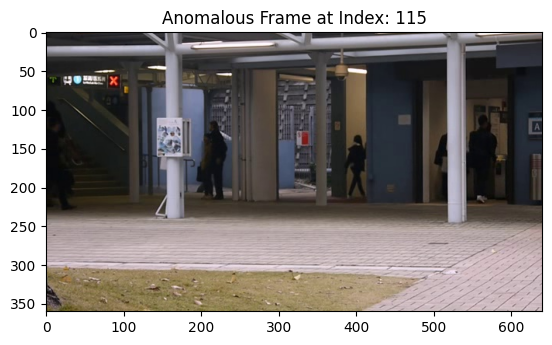

Anomalous Frame at Index: 116
Anomalous Frame at Index: 117
Anomalous Frame at Index: 118
Anomalous Frame at Index: 119
1/1 [==============================] - 0s 65ms/step
Anomalous bunch of frames at bunch number 12
Anomalous Frame at Index: 120
Anomalous Frame at Index: 121
Anomalous Frame at Index: 122
Anomalous Frame at Index: 123
Anomalous Frame at Index: 124
Anomalous Frame at Index: 125


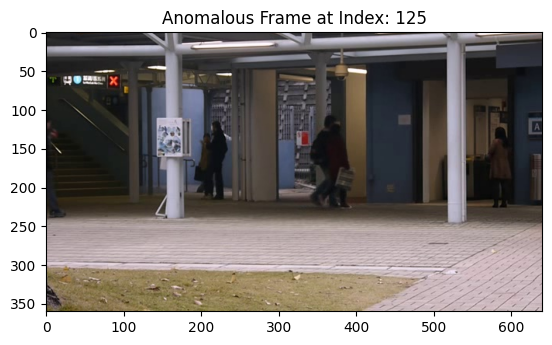

Anomalous Frame at Index: 126
Anomalous Frame at Index: 127
Anomalous Frame at Index: 128
Anomalous Frame at Index: 129
1/1 [==============================] - 0s 65ms/step
Anomalous bunch of frames at bunch number 13
Anomalous Frame at Index: 130
Anomalous Frame at Index: 131
Anomalous Frame at Index: 132
Anomalous Frame at Index: 133
Anomalous Frame at Index: 134
Anomalous Frame at Index: 135


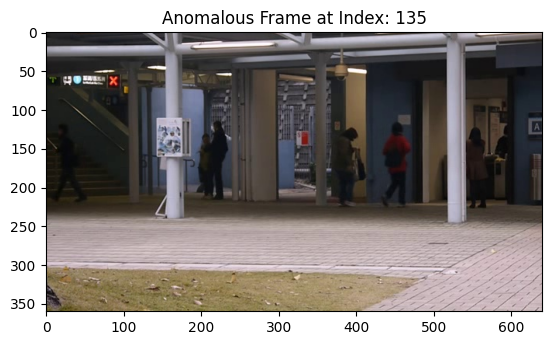

Anomalous Frame at Index: 136
Anomalous Frame at Index: 137
Anomalous Frame at Index: 138
Anomalous Frame at Index: 139
1/1 [==============================] - 0s 66ms/step
Anomalous bunch of frames at bunch number 14
Anomalous Frame at Index: 140
Anomalous Frame at Index: 141
Anomalous Frame at Index: 142
Anomalous Frame at Index: 143
Anomalous Frame at Index: 144
Anomalous Frame at Index: 145


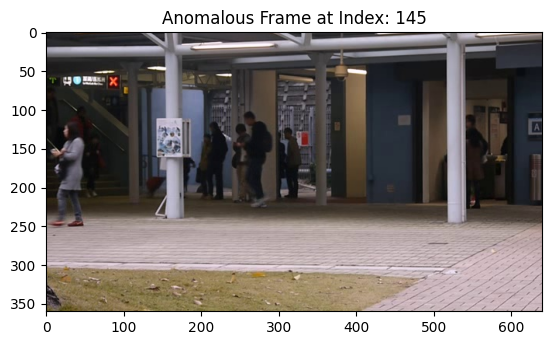

Anomalous Frame at Index: 146
Anomalous Frame at Index: 147
Anomalous Frame at Index: 148
Anomalous Frame at Index: 149
1/1 [==============================] - 0s 66ms/step
Anomalous bunch of frames at bunch number 15
Anomalous Frame at Index: 150
Anomalous Frame at Index: 151
Anomalous Frame at Index: 152
Anomalous Frame at Index: 153
Anomalous Frame at Index: 154
Anomalous Frame at Index: 155


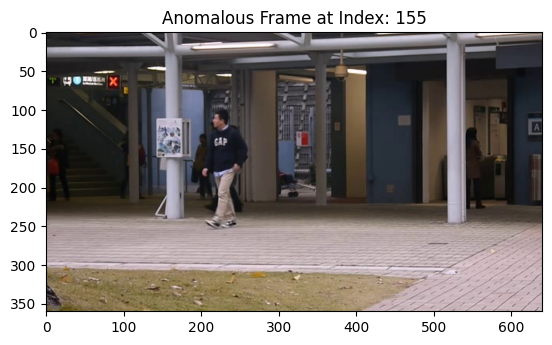

Anomalous Frame at Index: 156
Anomalous Frame at Index: 157
Anomalous Frame at Index: 158
Anomalous Frame at Index: 159
1/1 [==============================] - 0s 66ms/step
Anomalous bunch of frames at bunch number 16
Anomalous Frame at Index: 160
Anomalous Frame at Index: 161
Anomalous Frame at Index: 162
Anomalous Frame at Index: 163
Anomalous Frame at Index: 164
Anomalous Frame at Index: 165


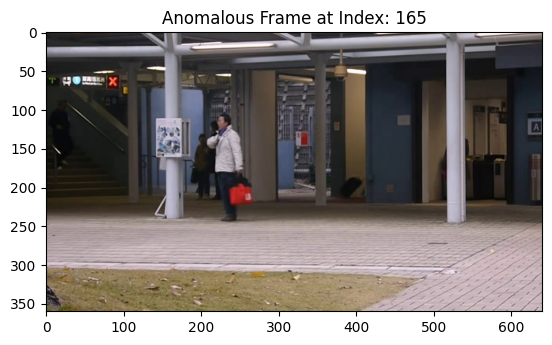

Anomalous Frame at Index: 166
Anomalous Frame at Index: 167
Anomalous Frame at Index: 168
Anomalous Frame at Index: 169
1/1 [==============================] - 0s 66ms/step
Anomalous bunch of frames at bunch number 17
Anomalous Frame at Index: 170
Anomalous Frame at Index: 171
Anomalous Frame at Index: 172
Anomalous Frame at Index: 173
Anomalous Frame at Index: 174
Anomalous Frame at Index: 175


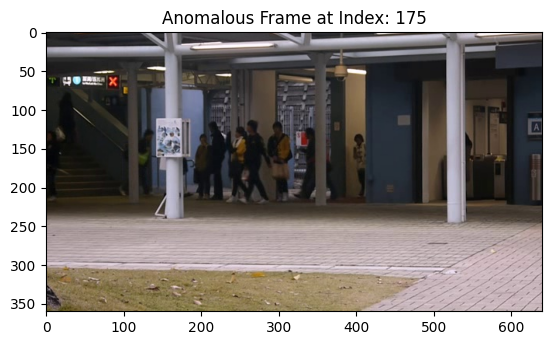

Anomalous Frame at Index: 176
Anomalous Frame at Index: 177
Anomalous Frame at Index: 178
Anomalous Frame at Index: 179
1/1 [==============================] - 0s 71ms/step
Anomalous bunch of frames at bunch number 18
Anomalous Frame at Index: 180
Anomalous Frame at Index: 181
Anomalous Frame at Index: 182
Anomalous Frame at Index: 183
Anomalous Frame at Index: 184
Anomalous Frame at Index: 185


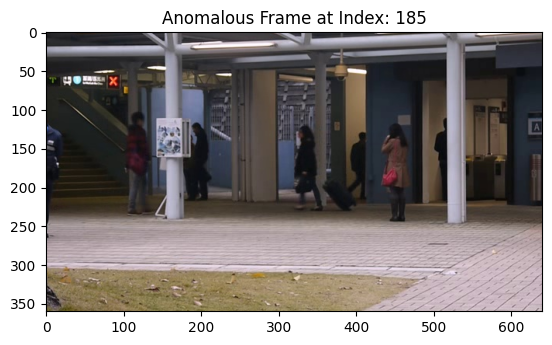

Anomalous Frame at Index: 186
Anomalous Frame at Index: 187
Anomalous Frame at Index: 188
Anomalous Frame at Index: 189
1/1 [==============================] - 0s 66ms/step
Bunch Normal
1/1 [==============================] - 0s 65ms/step
Bunch Normal
1/1 [==============================] - 0s 67ms/step
Bunch Normal
1/1 [==============================] - 0s 66ms/step
Bunch Normal
1/1 [==============================] - 0s 58ms/step
Bunch Normal
1/1 [==============================] - 0s 58ms/step
Bunch Normal
1/1 [==============================] - 0s 67ms/step
Bunch Normal
1/1 [==============================] - 0s 58ms/step
Anomalous bunch of frames at bunch number 26
Anomalous Frame at Index: 260
Anomalous Frame at Index: 261
Anomalous Frame at Index: 262
Anomalous Frame at Index: 263
Anomalous Frame at Index: 264
Anomalous Frame at Index: 265


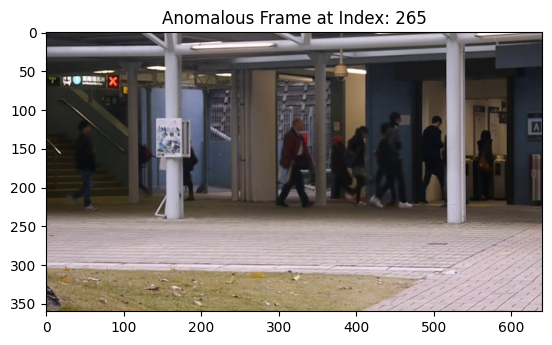

Anomalous Frame at Index: 266
Anomalous Frame at Index: 267
Anomalous Frame at Index: 268
Anomalous Frame at Index: 269
1/1 [==============================] - 0s 57ms/step
Anomalous bunch of frames at bunch number 27
Anomalous Frame at Index: 270
Anomalous Frame at Index: 271
Anomalous Frame at Index: 272
Anomalous Frame at Index: 273
Anomalous Frame at Index: 274
Anomalous Frame at Index: 275


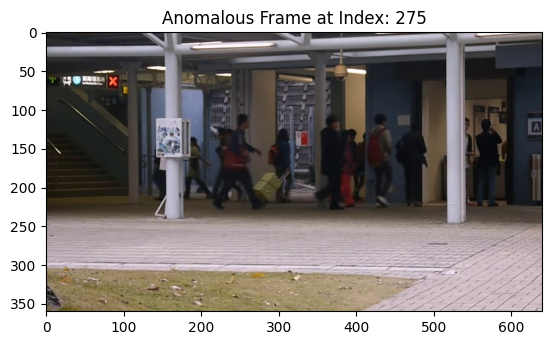

Anomalous Frame at Index: 276
Anomalous Frame at Index: 277
Anomalous Frame at Index: 278
Anomalous Frame at Index: 279
1/1 [==============================] - 0s 66ms/step
Anomalous bunch of frames at bunch number 28
Anomalous Frame at Index: 280
Anomalous Frame at Index: 281
Anomalous Frame at Index: 282
Anomalous Frame at Index: 283
Anomalous Frame at Index: 284
Anomalous Frame at Index: 285


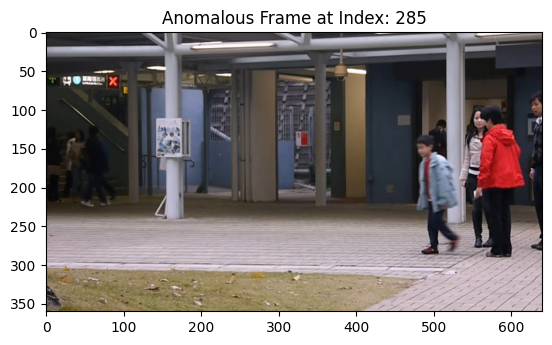

Anomalous Frame at Index: 286
Anomalous Frame at Index: 287
Anomalous Frame at Index: 288
Anomalous Frame at Index: 289
1/1 [==============================] - 0s 66ms/step
Bunch Normal
1/1 [==============================] - 0s 68ms/step
Bunch Normal
1/1 [==============================] - 0s 65ms/step
Bunch Normal
1/1 [==============================] - 0s 57ms/step
Bunch Normal
1/1 [==============================] - 0s 68ms/step
Bunch Normal
1/1 [==============================] - 0s 55ms/step
Bunch Normal
1/1 [==============================] - 0s 57ms/step
Bunch Normal
1/1 [==============================] - 0s 57ms/step
Bunch Normal
1/1 [==============================] - 0s 56ms/step
Bunch Normal
1/1 [==============================] - 0s 56ms/step
Bunch Normal
1/1 [==============================] - 0s 55ms/step
Bunch Normal
1/1 [==============================] - 0s 57ms/step
Bunch Normal
1/1 [==============================] - 0s 56ms/step
Bunch Normal
1/1 [==============================

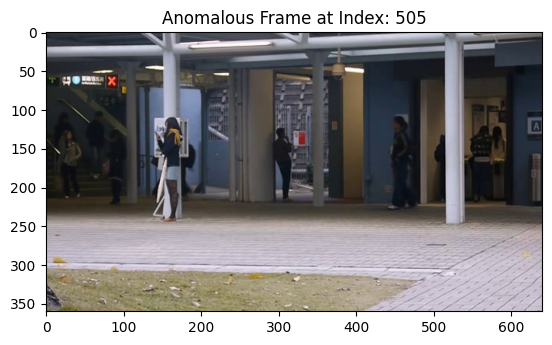

Anomalous Frame at Index: 506
Anomalous Frame at Index: 507
Anomalous Frame at Index: 508
Anomalous Frame at Index: 509
1/1 [==============================] - 0s 61ms/step
Anomalous bunch of frames at bunch number 51
Anomalous Frame at Index: 510
Anomalous Frame at Index: 511
Anomalous Frame at Index: 512
Anomalous Frame at Index: 513
Anomalous Frame at Index: 514
Anomalous Frame at Index: 515


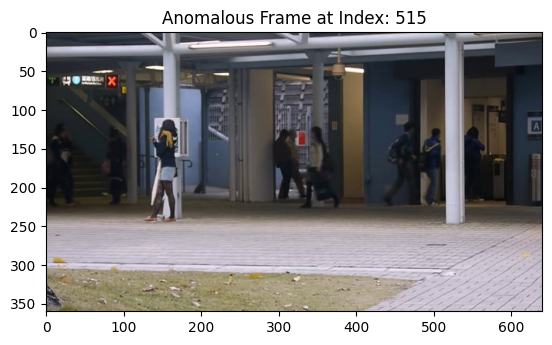

Anomalous Frame at Index: 516
Anomalous Frame at Index: 517
Anomalous Frame at Index: 518
Anomalous Frame at Index: 519
1/1 [==============================] - 0s 72ms/step
Anomalous bunch of frames at bunch number 52
Anomalous Frame at Index: 520
Anomalous Frame at Index: 521
Anomalous Frame at Index: 522
Anomalous Frame at Index: 523
Anomalous Frame at Index: 524
Anomalous Frame at Index: 525


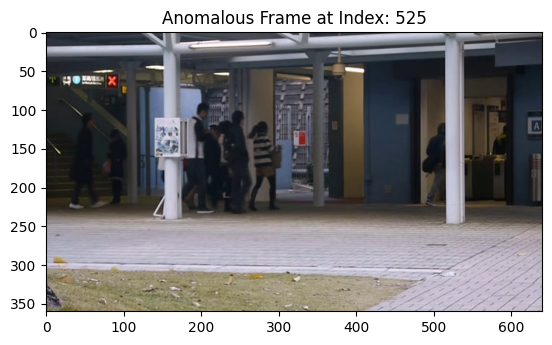

Anomalous Frame at Index: 526
Anomalous Frame at Index: 527
Anomalous Frame at Index: 528
Anomalous Frame at Index: 529
1/1 [==============================] - 0s 68ms/step
Anomalous bunch of frames at bunch number 53
Anomalous Frame at Index: 530
Anomalous Frame at Index: 531
Anomalous Frame at Index: 532
Anomalous Frame at Index: 533
Anomalous Frame at Index: 534
Anomalous Frame at Index: 535


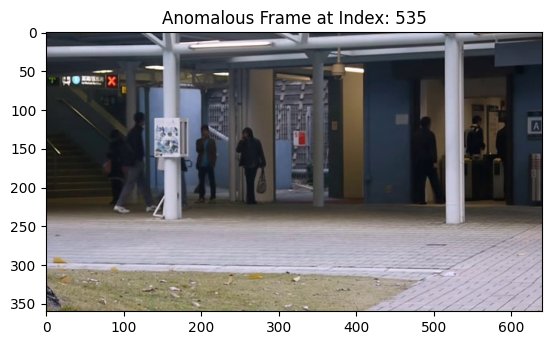

Anomalous Frame at Index: 536
Anomalous Frame at Index: 537
Anomalous Frame at Index: 538
Anomalous Frame at Index: 539
1/1 [==============================] - 0s 66ms/step
Anomalous bunch of frames at bunch number 54
Anomalous Frame at Index: 540
Anomalous Frame at Index: 541
Anomalous Frame at Index: 542
Anomalous Frame at Index: 543
Anomalous Frame at Index: 544
Anomalous Frame at Index: 545


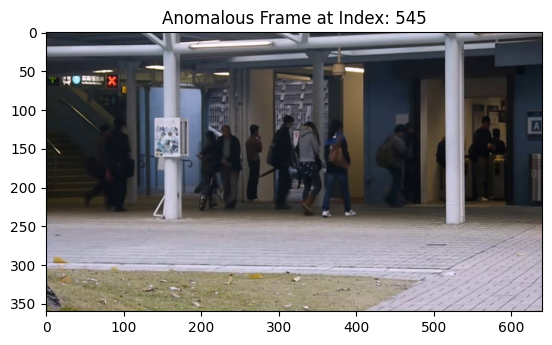

Anomalous Frame at Index: 546
Anomalous Frame at Index: 547
Anomalous Frame at Index: 548
Anomalous Frame at Index: 549
1/1 [==============================] - 0s 66ms/step
Anomalous bunch of frames at bunch number 55
Anomalous Frame at Index: 550
Anomalous Frame at Index: 551
Anomalous Frame at Index: 552
Anomalous Frame at Index: 553
Anomalous Frame at Index: 554
Anomalous Frame at Index: 555


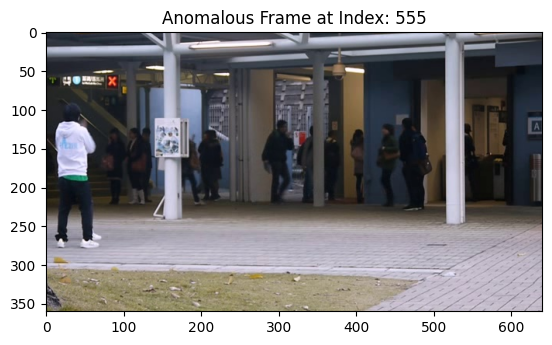

Anomalous Frame at Index: 556
Anomalous Frame at Index: 557
Anomalous Frame at Index: 558
Anomalous Frame at Index: 559
1/1 [==============================] - 0s 66ms/step
Anomalous bunch of frames at bunch number 56
Anomalous Frame at Index: 560
Anomalous Frame at Index: 561
Anomalous Frame at Index: 562
Anomalous Frame at Index: 563
Anomalous Frame at Index: 564
Anomalous Frame at Index: 565


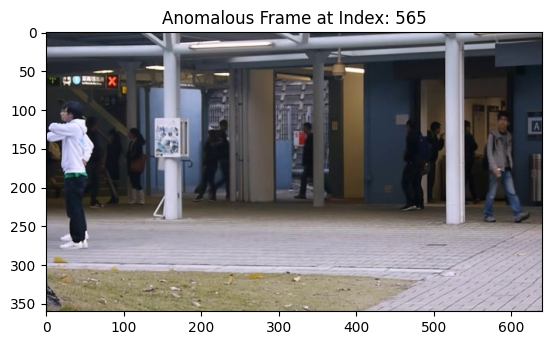

Anomalous Frame at Index: 566
Anomalous Frame at Index: 567
Anomalous Frame at Index: 568
Anomalous Frame at Index: 569
1/1 [==============================] - 0s 67ms/step
Anomalous bunch of frames at bunch number 57
Anomalous Frame at Index: 570
Anomalous Frame at Index: 571
Anomalous Frame at Index: 572
Anomalous Frame at Index: 573
Anomalous Frame at Index: 574
Anomalous Frame at Index: 575


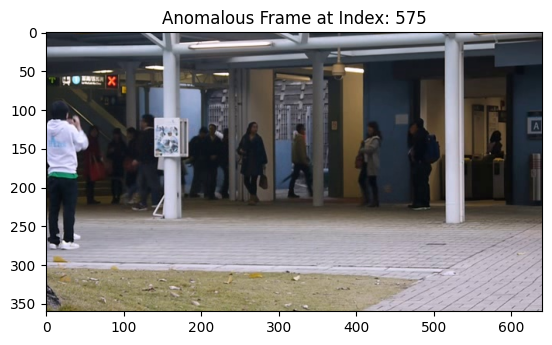

Anomalous Frame at Index: 576
Anomalous Frame at Index: 577
Anomalous Frame at Index: 578
Anomalous Frame at Index: 579
1/1 [==============================] - 0s 68ms/step
Anomalous bunch of frames at bunch number 58
Anomalous Frame at Index: 580
Anomalous Frame at Index: 581
Anomalous Frame at Index: 582
Anomalous Frame at Index: 583
Anomalous Frame at Index: 584
Anomalous Frame at Index: 585


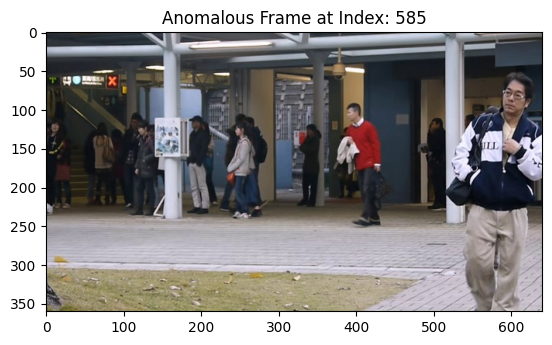

Anomalous Frame at Index: 586
Anomalous Frame at Index: 587
Anomalous Frame at Index: 588
Anomalous Frame at Index: 589
1/1 [==============================] - 0s 66ms/step
Anomalous bunch of frames at bunch number 59
Anomalous Frame at Index: 590
Anomalous Frame at Index: 591
Anomalous Frame at Index: 592
Anomalous Frame at Index: 593
Anomalous Frame at Index: 594
Anomalous Frame at Index: 595


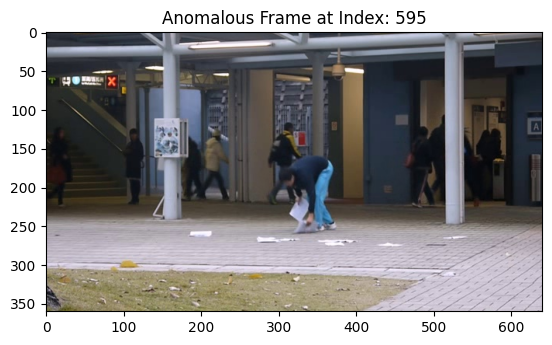

Anomalous Frame at Index: 596
Anomalous Frame at Index: 597
Anomalous Frame at Index: 598
Anomalous Frame at Index: 599
Anomalous Events detected


In [7]:
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import roc_auc_score
from keras.models import load_model
import scipy.io as sio

'''
Define threshold for Sensitivity
Lower the Threshhold,higher the chances that a bunch of frames will be flagged as Anomalous.
'''
loss_values=[]
threshold=0.00065
losses = []  # List to store losses
#labels = []  # List to store true labels (0 for normal, 1 for anomalous)
loaded_frame_paths_array = np.load(video_source_path_+'/frame_paths_Avenue_all.npy')
frame_paths = list(loaded_frame_paths_array)
video_source_path_1= "/content/drive/My Drive/ESML_Project/Processor"
#annotations_path = "/content/drive/My Drive/ESML_Project/Avenue Dataset/testing_vol"
model=load_model(video_source_path_1+'/AnomalyDetector_Avenue.h5')
X_test=np.load(video_source_path_1+'/testing_Avenue_all.npy')
frames=X_test.shape[2]
print(frames)
flag=0 #Overall video flagq
frames=frames-frames%10
X_test=X_test[:,:,:frames]
X_test=X_test.reshape(-1,227,227,10)
X_test=np.expand_dims(X_test,axis=4)


for number, bunch in enumerate(X_test):
    n_bunch = np.expand_dims(bunch, axis=0)
    reconstructed_bunch = model.predict(n_bunch)
    loss = mean_squared_loss(n_bunch, reconstructed_bunch)
    loss_values.append(loss)  # Append the loss to the list
    #labels.append(1 if loss > threshold else 0)

    if loss > threshold:

        # Process each frame in the bunch with YOLO
        flag = 1
        print("Anomalous bunch of frames at bunch number {}".format(number))
        start_index = number * 10  # Assuming each bunch has 10 frames
        for i in range(10):
          losses.append(1)
          frame_index =  start_index+ i
          print('Anomalous Frame at Index:',frame_index)

          if i==5:
                frame_path = frame_paths[frame_index]
                #print(frame_path)
                frame = cv2.imread(frame_path, cv2.IMREAD_COLOR)
                if frame is None:
                    print("frame is none")
                    continue

                #print(frame)
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                plt.imshow(frame)
                plt.title(f'Anomalous Frame at Index: {frame_index}')
                plt.show()  # Display the image

    else:
        print('Bunch Normal')
        for i in range(10):
          losses.append(0)


if flag == 1:
    print("Anomalous Events detected")

#    mat_file_path = 'annotations_path/avenue_annotations.mat'
#   annotations = sio.loadmat(mat_file_path)

In [28]:
labels_np=np.load(video_source_path_1+'/Avenue_test_labels_array.npy')
labels=list(labels_np)
len(labels)

600

<Figure size 2000x400 with 0 Axes>

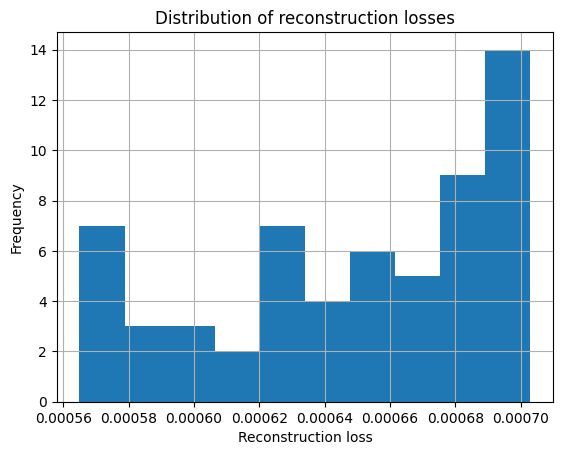

<Figure size 2000x400 with 0 Axes>

In [12]:
plt.hist(loss_values)  # Histogram
plt.xlabel("Reconstruction loss")
plt.ylabel("Frequency")

plt.title("Distribution of reconstruction losses")
plt.grid(True)
plt.figure(figsize=(20, 4))
#plt.show()

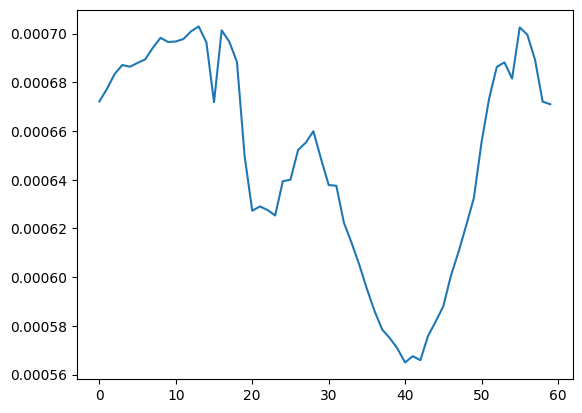

In [13]:
plt.plot(loss_values)

In [41]:
#print(len(losses))
auc_score = roc_auc_score(labels, losses)
print(f"AUC Score: {auc_score}")

AUC Score: 0.8174890819864031


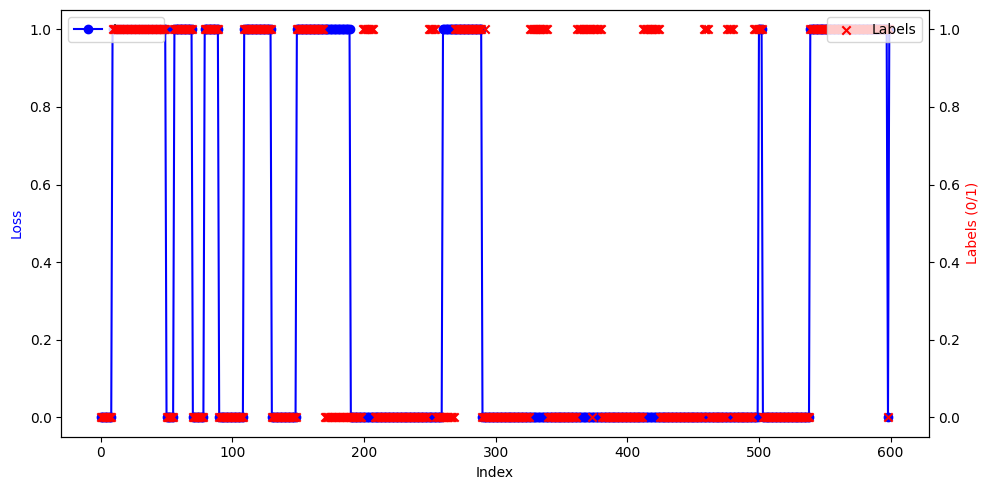

In [45]:
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot losses as a line chart
ax1.plot(losses, color="blue", marker="o", linestyle="-", label="Losses")
ax1.set_ylabel("Loss", color="blue")

# Plot labels as a scatter plot
ax2 = ax1.twinx()  # Create a twin axis for labels
ax2.scatter(range(len(labels)), labels, color="red", marker="x", label="Labels")
ax2.set_ylabel("Labels (0/1)", color="red")

# Set x-axis label
ax1.set_xlabel("Index")

# Add legend
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

# Adjust plot layout
plt.tight_layout()

# Show the plot
plt.show()

In [42]:
y_test=labels
y_pred=losses
from sklearn import metrics
print("Accuracy =", metrics.accuracy_score(y_test, y_pred))
print("Confusion Matrix =\n", metrics.confusion_matrix(y_test, y_pred, labels=None,
                                              sample_weight=None))
print("Recall =", metrics.recall_score(y_test, y_pred, labels=None,
                                             pos_label=1, average='weighted',
                                             sample_weight=None))
print("Classification Report =\n", metrics.classification_report(y_test, y_pred,
                                                                 labels=None,
                                                                 target_names=None,
                                                                 sample_weight=None,
                                                                 digits=2,
                                                                 output_dict=False))

Accuracy = 0.8283333333333334
Confusion Matrix =
 [[305  29]
 [ 74 192]]
Recall = 0.8283333333333334
Classification Report =
               precision    recall  f1-score   support

           0       0.80      0.91      0.86       334
           1       0.87      0.72      0.79       266

    accuracy                           0.83       600
   macro avg       0.84      0.82      0.82       600
weighted avg       0.83      0.83      0.83       600



In [43]:
losses_np = np.array(losses)
#print(frame_paths_array)
np.save(video_source_path_1+'/Avenue_test_losses.npy', losses_np)
labels_np = np.array(labels)
#print(frame_paths_array)
np.save((video_source_path_1+'/Avenue_test_labels_array.npy'), labels_np)